<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [3]:
import random
import io
import pickle

import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

/home/martin/Documents/CEIA/CEIA-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# # descargar de textos.info
# import urllib.request

# # Para leer y parsear el texto en HTML de wikipedia
# import bs4 as bs

In [ ]:
# raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
# raw_html = raw_html.read()

# # Parsear artículo, 'lxml' es el parser a utilizar
# article_html = bs.BeautifulSoup(raw_html, 'lxml')

# # Encontrar todos los párrafos del HTML (bajo el tag <p>)
# # y tenerlos disponible como lista
# article_paragraphs = article_html.find_all('p')

# article_text = ''

# for para in article_paragraphs:
#     article_text += para.text + ' '

# # pasar todo el texto a minúscula
# article_text = article_text.lower()

In [4]:
# Elijo como dataset las novelas de Harry Potter disponibles Hugging Face


# Load dataset from HF
dataset = load_dataset("elricwan/HarryPotter", split="train")

# Convert to pandas DataFrame if needed
df_HarryPotter = dataset.to_pandas()

print(df_HarryPotter.head())

                                          filename  \
0      1-Harry-Potter-and-the-Sorcerer’s-Stone.txt   
1    2-Harry-Potter-and-the-Chamber-of-Secrets.txt   
2   3-Harry-Potter-and-the-Prisoner-of-Azkaban.txt   
3        4-Harry-Potter-and-the-Goblet-of-Fire.txt   
4  5-Harry-Potter-and-the-Order-of-the-Phoenix.txt   

                                             content  
0  FOR JESSICA, WHO LOVES STORIES,\n\nFOR ANNE, W...  
1  FOR SEÁN P. F. HARRIS,\n\nGETAWAY DRIVER AND F...  
2  TO JILL PREWETT AND\n\nAINE KIELY,\n\nTHE GODM...  
3  TO PETER ROWLING,\n\nIN MEMORY OF MR. RIDLEY\n...  
4  TO NEIL, JESSICA, AND DAVID,\n\nWHO MAKE MY WO...  


In [10]:
print("Cantidad de documentos:", df_HarryPotter.shape[0])
print("Nombre de las columnas del DF: ", df_HarryPotter.columns)

Cantidad de documentos: 8
Nombre de las columnas del DF:  Index(['filename', 'content'], dtype='object')


In [22]:
# Producimos un solo texto de todo el contenido del dataframe
article_text = ' '.join(df_HarryPotter['content'].astype(str).tolist())
article_text = article_text.lower()
print(f"\nTotal de caracteres presentes: {len(article_text)}")
print(f"\nPrimeros 30 caracteres:\n{article_text[:30]}")


Total de caracteres presentes: 12982419

Primeros 30 caracteres:
for jessica, who loves stories


### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [21]:
# seleccionamos el tamaño de contexto
max_context_size = 500

In [5]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Torch
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
# from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [ ]:
# Verificamos la cantidad de caracteres y el vocabulario y la calidad del texto elegido
print(f"Total de caracteres: {len(article_text):,}")
print(f"Primeros 200 caracteres:\n{article_text[:200]}")
print(f"\nÚltimos 200 caracteres:\n{article_text[-200:]}")

#  en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)
print(f"\nTamaño del vocabulario: {len(chars_vocab)} caracteres únicos")
print(f"Caracteres en el vocabulario:\n{sorted(chars_vocab)}")

# Ejemplos de consultas al vocabulario
print(f"\n¿Tiene letras? {'a' in chars_vocab and 'z' in chars_vocab}")
print(f"¿Tiene números? {'0' in chars_vocab or '1' in chars_vocab}")
print(f"¿Tiene espacios? {' ' in chars_vocab}")
print(f"¿Tiene puntuación? {'.' in chars_vocab and ',' in chars_vocab}")

Total de caracteres: 12,982,419
Primeros 200 caracteres:
for jessica, who loves stories,

for anne, who loved them too;

and for di, who heard this one first.





contents



one

the boy who lived



two

the vanishing glass



three

the letters from no 

Últimos 200 caracteres:
 retrieval system, or transmitted in any form or by any means, electronic, mechanical, photocopying, recording, or otherwise, without written permission of the publisher.

isbn 978-1-78110-243-5







Tamaño del vocabulario: 63 caracteres únicos
Caracteres en el vocabulario:
['\n', ' ', '!', '&', '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '©', 'ß', 'á', 'é', 'ù', '–', '—', '‘', '’', '“', '”', '…', '™']

¿Tiene letras? True
¿Tiene números? True
¿Tiene espacios? True
¿Tiene puntuación? True


In [24]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [25]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [26]:
tokenized_text[:1000]

[57,
 56,
 48,
 22,
 40,
 27,
 34,
 34,
 1,
 6,
 46,
 55,
 22,
 20,
 44,
 56,
 22,
 42,
 56,
 4,
 27,
 34,
 22,
 34,
 53,
 56,
 48,
 1,
 27,
 34,
 55,
 17,
 17,
 57,
 56,
 48,
 22,
 46,
 12,
 12,
 27,
 55,
 22,
 20,
 44,
 56,
 22,
 42,
 56,
 4,
 27,
 18,
 22,
 53,
 44,
 27,
 41,
 22,
 53,
 56,
 56,
 36,
 17,
 17,
 46,
 12,
 18,
 22,
 57,
 56,
 48,
 22,
 18,
 1,
 55,
 22,
 20,
 44,
 56,
 22,
 44,
 27,
 46,
 48,
 18,
 22,
 53,
 44,
 1,
 34,
 22,
 56,
 12,
 27,
 22,
 57,
 1,
 48,
 34,
 53,
 43,
 17,
 17,
 17,
 17,
 17,
 17,
 6,
 56,
 12,
 53,
 27,
 12,
 53,
 34,
 17,
 17,
 17,
 17,
 56,
 12,
 27,
 17,
 17,
 53,
 44,
 27,
 22,
 62,
 56,
 5,
 22,
 20,
 44,
 56,
 22,
 42,
 1,
 4,
 27,
 18,
 17,
 17,
 17,
 17,
 53,
 20,
 56,
 17,
 17,
 53,
 44,
 27,
 22,
 4,
 46,
 12,
 1,
 34,
 44,
 1,
 12,
 16,
 22,
 16,
 42,
 46,
 34,
 34,
 17,
 17,
 17,
 17,
 53,
 44,
 48,
 27,
 27,
 17,
 17,
 53,
 44,
 27,
 22,
 42,
 27,
 53,
 53,
 27,
 48,
 34,
 22,
 57,
 48,
 56,
 41,
 22,
 12,
 56,
 22,
 56,
 12,
 27,


### Organizando y estructurando el dataset

In [27]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [28]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [ ]:
# tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [ ]:
# tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
# X = np.array(tokenized_sentences_train[:-1])
# y = np.array(tokenized_sentences_train[1:])

In [31]:
# Cambiamos las funciones de tokenización y padding a PyTorch para utilizar GPU, mejorar los tiempos de procesamiento y evitar errores de memoria.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Validation sequences
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] 
                           for init in range(num_val)]

# Training sequences - PyTorch unfold
print("Creating training sequences...")
train_tensor = torch.tensor(train_text, dtype=torch.long)
tokenized_sentences_train = train_tensor.unfold(0, max_context_size, 1)

print(f"Training sequences: {tokenized_sentences_train.shape}")

# Create X and y as PyTorch tensors
X = tokenized_sentences_train[:-1]  # Keep as tensor
y = tokenized_sentences_train[1:]   # Keep as tensor

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Using device: cuda
Creating training sequences...
Training sequences: torch.Size([11683420, 500])
X shape: torch.Size([11683419, 500])
y shape: torch.Size([11683419, 500])


Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [32]:
X.shape

torch.Size([11683419, 500])

In [33]:
X[0,:10]

tensor([57, 56, 48, 22, 40, 27, 34, 34,  1,  6])

In [34]:
y[0,:10]

tensor([56, 48, 22, 40, 27, 34, 34,  1,  6, 46])

In [35]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200):
        super().__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(
            input_size=vocab_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len, 1) con índices enteros
        x = x.squeeze(-1).long()                   # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()  # (batch, seq_len, vocab_size)

        out, _ = self.rnn(x)                      # (batch, seq_len, hidden_size)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out                                # logits (sin softmax)


model = RNNModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

print(model)

RNNModel(
  (rnn): RNN(63, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=63, bias=True)
)



### Definir el modelo

In [38]:
class TrainerWithPerplexity:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, patience=5, device="cpu"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.device = device

        self.min_score = float("inf")
        self.patience_counter = 0
        self.history_ppl = []

    def compute_perplexity(self):
        self.model.eval()
        scores = []
        with torch.no_grad():
            for xb, yb in self.val_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                logits = self.model(xb)  # (batch, seq_len, vocab_size)

                # tomamos la probabilidad del último token predicho
                log_probs = F.log_softmax(logits, dim=-1)

                target = yb[:, -1]  # último token
                probs = log_probs[:, -1, :]

                chosen_log_probs = probs[range(len(target)), target]
                ppl = torch.exp(-chosen_log_probs.mean()).item()
                scores.append(ppl)
        return np.mean(scores)

    def train(self, num_epochs=20, save_path="best_model.pt"):
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            for xb, yb in self.train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(xb)

                # logits: (batch, seq_len, vocab_size)
                # target: (batch, seq_len)
                loss = self.criterion(logits.transpose(1, 2), yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_loader)

            # calcular ppl en validación
            current_ppl = self.compute_perplexity()
            self.history_ppl.append(current_ppl)

            print(f"Epoch {epoch+1}: train loss={avg_loss:.4f}, val ppl={current_ppl:.4f}")

            # early stopping
            if current_ppl < self.min_score:
                self.min_score = current_ppl
                torch.save(self.model.state_dict(), save_path)
                print("Saved new best model!")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    break



### Entrenamiento

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
batch_size = 256
num_epochs = 20
patience = 5
# Como al crear los tokenized_sentences_train usamos PyTorch, podemos crear el DataLoader directamente
train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=256, 
                                           shuffle=True,
                                           pin_memory=True) 

# train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.long),
#                                                torch.tensor(y, dtype=torch.long))
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def prepare_val_data(val_data, max_context_size, vocab_size):
    targets, padded = [], []
    info = []
    count = 0

    for seq in val_data:
        len_seq = len(seq)
        subseq = [seq[:i] for i in range(1, len_seq)]
        targets.extend([seq[i] for i in range(1, len_seq)])

        if len(subseq) != 0:
            arr = np.zeros((len(subseq), max_context_size), dtype=np.int64)
            for j, s in enumerate(subseq):
                # truncar si es más larga
                s = s[-max_context_size:]
                arr[j, -len(s):] = s
            padded.append(arr)
            info.append((count, count + len_seq))
            count += len_seq

    padded = np.vstack(padded)
    return torch.tensor(padded, dtype=torch.long), torch.tensor(targets, dtype=torch.long), info


def compute_perplexity(model, val_inputs, val_targets, batch_size=256):
    model.eval()
    all_log_probs = []
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)

            logits = model(xb.unsqueeze(-1))  # tu modelo espera (batch, seq_len, 1)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())

    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

history_ppl = []
min_score = float("inf")
patience_counter = 0

# preparar datos de validación
val_inputs, val_targets, val_info = prepare_val_data(tokenized_sentences_val,
                                                     max_context_size=max_context_size,
                                                     vocab_size=vocab_size)

# --- training loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb.unsqueeze(-1))   # logits: (batch, seq_len, vocab_size)
        loss = criterion(logits.transpose(1, 2), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    current_ppl = compute_perplexity(model, val_inputs, val_targets, batch_size=batch_size)
    history_ppl.append(current_ppl)

    print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")

    # early stopping
    if current_ppl < min_score:
        min_score = current_ppl
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved new best model!")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20 - loss: 1.3148 - val_ppl: 3.6999
Saved new best model!
Epoch 2/20 - loss: 1.2450 - val_ppl: 3.6194
Saved new best model!
Epoch 3/20 - loss: 1.2362 - val_ppl: 3.6159
Saved new best model!
Epoch 4/20 - loss: 1.2314 - val_ppl: 3.5871
Saved new best model!
Epoch 5/20 - loss: 1.2284 - val_ppl: 3.5779
Saved new best model!
Epoch 6/20 - loss: 1.2263 - val_ppl: 3.5652
Saved new best model!
Epoch 7/20 - loss: 1.2248 - val_ppl: 3.5695
Epoch 8/20 - loss: 1.2237 - val_ppl: 3.5734
Epoch 9/20 - loss: 1.2229 - val_ppl: 3.5651
Saved new best model!
Epoch 10/20 - loss: 1.2221 - val_ppl: 3.5498
Saved new best model!
Epoch 11/20 - loss: 1.2214 - val_ppl: 3.5626
Epoch 12/20 - loss: 1.2210 - val_ppl: 3.5651
Epoch 13/20 - loss: 1.2206 - val_ppl: 3.5555
Epoch 14/20 - loss: 1.2203 - val_ppl: 3.5550
Epoch 15/20 - loss: 1.2200 - val_ppl: 3.5494
Saved new best model!
Epoch 16/20 - loss: 1.2197 - val_ppl: 3.5634
Epoch 17/20 - loss: 1.2195 - val_ppl: 3.5698
Epoch 18/20 - loss: 1.2191 - val_ppl: 3.5508
E

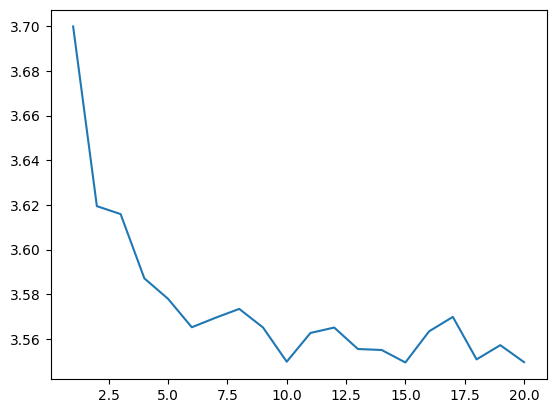

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

# !pip install -q gradio

In [42]:
import gradio as gr

def model_response(human_text):
    model.eval()  # modo evaluación

    # encodeamos
    encoded = [char2idx.get(ch, 0) for ch in human_text.lower()]  # si el char no está, 0
    if len(encoded) > max_context_size:
        encoded = encoded[-max_context_size:]  # truncar
    else:
        encoded = [0]*(max_context_size - len(encoded)) + encoded  # pad izquierda

    # tensor al device correcto
    x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)
    # shape: (1, seq_len=max_context_size, 1)

    # forward
    with torch.no_grad():
        logits = model(x)              # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1)  # último timestep

    y_hat = torch.argmax(probs).item()
    out_word = idx2char[y_hat]

    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [43]:
def generate_seq(model, seed_text, max_length, n_words):
    model.eval()
    device = next(model.parameters()).device  # detecta si está en cpu o cuda
    output_text = seed_text

    for _ in range(n_words):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()]  # si no está → 0

        # truncar o padear a max_length
        if len(encoded) > max_length:
            encoded = encoded[-max_length:]
        else:
            encoded = [0] * (max_length - len(encoded)) + encoded

        # convertir a tensor (batch=1, seq_len=max_length, 1)
        x = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

        # --- Forward ---
        with torch.no_grad():
            logits = model(x)  # (1, seq_len, vocab_size)
            probs = F.softmax(logits[0, -1, :], dim=-1)
            y_hat = torch.argmax(probs).item()

        # convertir a caracter
        out_char = idx2char[y_hat]
        output_text += out_char

    return output_text

In [48]:
input_text='Once upon a time there was a'

generate_seq(model, input_text, max_length=max_context_size, n_words=80)

'Once upon a time there was a students when he had not to see her seat and the stairs to have to see him and '

###  Beam search y muestreo aleatorio

In [49]:
import torch

def encode(text, max_length=max_context_size, device=None):
    # convertir cada caracter a índice (si no está en vocabulario, usar 0)
    encoded = [char2idx.get(ch, 0) for ch in text.lower()]

    # truncar o padear
    if len(encoded) > max_length:
        encoded = encoded[-max_length:]
    else:
        encoded = [0] * (max_length - len(encoded)) + encoded

    # convertir a tensor (batch=1, seq_len, 1)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).unsqueeze(-1)

    if device is not None:
        tensor = tensor.to(device)
    return tensor


def decode(seq):
    if torch.is_tensor(seq):
        seq = seq.cpu().numpy().tolist()
    return ''.join([idx2char[ch] for ch in seq])

In [50]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []

    for idx, pp in enumerate(pred):
        # sumamos los log probs acumulados
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]),
            num_beams,
            p=softmax(pred_large / temp)
        )
    else:
        raise ValueError(f"Wrong selection mode: {mode}. Use 'det' or 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words, input_text, max_length,temp=1.0, mode='det'):
    model.eval()
    device = next(model.parameters()).device

    encoded = encode(input_text, max_length=max_length, device=device)  # (1, seq_len, 1)

    with torch.no_grad():
        logits = model(encoded)  # (1, seq_len, vocab_size)
        probs = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

    vocab_size = probs.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded.squeeze(-1).cpu().numpy()[0]] * num_beams  # shape: (seq_len,)

    # seleccionar primeros candidatos
    history_probs, history_tokens = select_candidates([probs],
                                                      num_beams,
                                                      vocab_size,
                                                      history_probs,
                                                      history_tokens,
                                                      temp,
                                                      mode)

    #loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            # mantener contexto de tamaño max_length
            input_update = hist[-max_length:]
            x = torch.tensor(input_update, dtype=torch.long).unsqueeze(0).unsqueeze(-1).to(device)

            with torch.no_grad():
                logits = model(x)
                y_hat = F.softmax(logits[0, -1, :], dim=-1).cpu().numpy()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds,
                                                          num_beams,
                                                          vocab_size,
                                                          history_probs,
                                                          history_tokens,
                                                          temp,
                                                          mode)

    # devolver secuencias generadas (últimos tokens relevantes)
    return history_tokens[:, -(len(input_text) + num_words):]


In [51]:
max_context_size

500

In [55]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=200,input_text="Once upon a time",max_length=max_context_size,temp=1,mode="sto")

In [56]:
salidas[0]

array([56, 12,  6, 27, 22,  3, 10, 56, 12, 22, 46, 22, 53,  1, 41, 27, 22,
       43, 22, 43, 22, 43, 22, 53, 44, 46, 53, 22, 20, 46, 34, 22, 53, 44,
       27, 22, 53, 44, 48, 27, 27, 22, 56, 57, 22, 53, 44, 27, 41, 22, 20,
       46, 34, 22, 34, 27, 27, 41, 27, 18, 22, 53, 56, 22, 44, 46,  4, 27,
       22, 53, 56, 22, 44, 46,  4, 27, 22, 62, 27, 27, 12, 22,  6, 56, 12,
       53,  1, 12,  3, 27, 18, 22, 53, 56, 22, 44, 46,  4, 27, 22, 53, 56,
       22, 62, 27, 22, 46, 42, 42, 22, 48,  1, 16, 44, 53, 55,  9, 22, 34,
       46,  1, 18, 22, 44, 46, 48, 48,  5, 55, 22, 46, 12, 18, 22, 44, 27,
       48, 41,  1, 56, 12, 27, 22, 46, 12, 18, 22, 44, 27, 48, 41,  1, 56,
       12, 27, 22, 20, 27, 48, 27, 22, 56, 12, 22, 53, 44, 27, 22, 57, 42,
       56, 56, 48, 43, 22, 44, 27, 22, 20, 46, 34, 22, 46, 42, 42, 22, 53,
       44, 27, 22, 57,  1, 48, 34, 53, 22, 53,  1, 41, 27, 22,  1, 12, 22,
       53, 44, 27, 22, 56, 53, 44, 27, 48, 22, 34, 27])

In [57]:
# veamos las salidas
decode(salidas[0])

'once upon a time . . . that was the three of them was seemed to have to have been continued to have to be all right,” said harry, and hermione and hermione were on the floor. he was all the first time in the other se'

#### El texto generado carece de sentido gramatical y estructura, pero pareciera captar algunas de los componentes principales de la historia: La referencia a los tres personajes principales.

## LSTM Model:

In [58]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, num_layers=1, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        # x: (batch, seq_len, 1) con indices enteros
        x = x.squeeze(-1).long()                                    # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()      # (batch, seq_len, vocab_size)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)                     # lstm_out: (batch, seq_len, hidden_size)
        
        # Aplicar capa de salida a todos los timesteps
        out = self.fc(lstm_out)                                     # (batch, seq_len, vocab_size)
        
        return out  # returns logits (no softmax)


### Modelo GRU

In [59]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, num_layers=1, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        # x: (batch, seq_len, 1) with integer indices
        x = x.squeeze(-1).long()                                    # (batch, seq_len)
        x = F.one_hot(x, num_classes=self.vocab_size).float()      # (batch, seq_len, vocab_size)
        
        # GRU forward pass
        gru_out, hidden = self.gru(x)                               # gru_out: (batch, seq_len, hidden_size)
        
        # Apply output layer
        out = self.fc(gru_out)                                      # (batch, seq_len, vocab_size)
        
        return out

### La funcion de entrenamiento es comun a los dos modelos:

In [ ]:
def train_model(model, train_loader, val_inputs, val_targets, 
                model_name="model", num_epochs=20, patience=5, 
                learning_rate=0.001, device="cuda"):
    """
    Sirve para entrenar modelos RNN/LSTM/GRU
    
    Returns:
        history_ppl: lista de validacion de perplejidades
        min_ppl: mejor validacion de perplejidad
    """
    print(f"\n{'='*60}")
    print(f"Entrenando: {model_name}")
    print(f"{'='*60}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    history_ppl = []
    min_score = float("inf")
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            logits = model(xb.unsqueeze(-1))
            loss = criterion(logits.transpose(1, 2), yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # Validation phase
        current_ppl = compute_perplexity(model, val_inputs, val_targets, 
                                        batch_size=256, device=device)
        history_ppl.append(current_ppl)
        
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - val_ppl: {current_ppl:.4f}")
        
        # Early stopping
        if current_ppl < min_score:
            min_score = current_ppl
            torch.save(model.state_dict(), f"best_{model_name}.pt")
            print(f"  → Saved new best model!")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Se activo el Early stopping")
                break
    
    print(f"{'='*60}")
    print(f"Best validation perplexity: {min_score:.4f}")
    print(f"{'='*60}\n")
    
    return history_ppl, min_score


def compute_perplexity(model, val_inputs, val_targets, batch_size=256, device="cuda"):
    """Calcular perplexity sobre datos de validación"""
    model.eval()
    all_log_probs = []
    
    with torch.no_grad():
        for i in range(0, len(val_inputs), batch_size):
            xb = val_inputs[i:i+batch_size].to(device)
            yb = val_targets[i:i+batch_size].to(device)
            
            logits = model(xb.unsqueeze(-1))
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            chosen = log_probs[range(len(yb)), yb]
            all_log_probs.extend(chosen.cpu().numpy())
    
    all_log_probs = np.array(all_log_probs)
    ppl = float(np.exp(-all_log_probs.mean()))
    return ppl

In [61]:
#Desarrollamos el entrenamiento de los tres modelos y comparamos resultados

# Buscamos GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Training parameters
batch_size = 256
num_epochs = 20
patience = 5
learning_rate = 0.001

# Preparar data loaders 
train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    pin_memory=True
)

# Preparar los datos para la validacion
val_inputs, val_targets, val_info = prepare_val_data(
    tokenized_sentences_val,
    max_context_size=max_context_size,
    vocab_size=vocab_size
)

# Diccionario para guardar resultados
results = {}

# ============================================
# 1. Entrenar SimpleRNN --> Si bien lo hice antes, lo vuelvo a hacer para comparar resultados
# ============================================
print("\n" + "="*60)
print("Entrenando SIMPLERNN")
print("="*60)

model_rnn = RNNModel(vocab_size, hidden_size=200).to(device)
history_rnn, min_ppl_rnn = train_model(
    model_rnn, train_loader, val_inputs, val_targets,
    model_name="SimpleRNN",
    num_epochs=num_epochs,
    patience=patience,
    learning_rate=learning_rate,
    device=device
)
results['SimpleRNN'] = {'history': history_rnn, 'best_ppl': min_ppl_rnn}

# ============================================
# 2. Entrenar LSTM
# ============================================
print("\n" + "="*60)
print("Entrenando LSTM")
print("="*60)

model_lstm = LSTMModel(vocab_size, hidden_size=200, num_layers=1).to(device)
history_lstm, min_ppl_lstm = train_model(
    model_lstm, train_loader, val_inputs, val_targets,
    model_name="LSTM",
    num_epochs=num_epochs,
    patience=patience,
    learning_rate=learning_rate,
    device=device
)
results['LSTM'] = {'history': history_lstm, 'best_ppl': min_ppl_lstm}

# ============================================
# 3. Entrenar GRU
# ============================================
print("\n" + "="*60)
print("Entrenando GRU")
print("="*60)

model_gru = GRUModel(vocab_size, hidden_size=200, num_layers=1).to(device)
history_gru, min_ppl_gru = train_model(
    model_gru, train_loader, val_inputs, val_targets,
    model_name="GRU",
    num_epochs=num_epochs,
    patience=patience,
    learning_rate=learning_rate,
    device=device
)
results['GRU'] = {'history': history_gru, 'best_ppl': min_ppl_gru}

# ============================================
# 4. Comparar resultados
# ============================================
print("\n" + "="*60)
print("COMPARACIÓN DE RESULTADOS")
print("="*60)

for model_name, result in results.items():
    print(f"{model_name:12s} - Best Perplexity: {result['best_ppl']:.4f}")

Using device: cuda

Entrenando SIMPLERNN

Training SimpleRNN
Epoch 1/20 - loss: 1.3174 - val_ppl: 3.6518
  → Saved new best model!
Epoch 2/20 - loss: 1.2441 - val_ppl: 3.6087
  → Saved new best model!
Epoch 3/20 - loss: 1.2347 - val_ppl: 3.5970
  → Saved new best model!
Epoch 4/20 - loss: 1.2301 - val_ppl: 3.5636
  → Saved new best model!
Epoch 5/20 - loss: 1.2271 - val_ppl: 3.5648
Epoch 6/20 - loss: 1.2252 - val_ppl: 3.5569
  → Saved new best model!
Epoch 7/20 - loss: 1.2238 - val_ppl: 3.5710
Epoch 8/20 - loss: 1.2229 - val_ppl: 3.5615
Epoch 9/20 - loss: 1.2222 - val_ppl: 3.5512
  → Saved new best model!
Epoch 10/20 - loss: 1.2217 - val_ppl: 3.5523
Epoch 11/20 - loss: 1.2211 - val_ppl: 3.5684
Epoch 12/20 - loss: 1.2207 - val_ppl: 3.5551
Epoch 13/20 - loss: 1.2202 - val_ppl: 3.5349
  → Saved new best model!
Epoch 14/20 - loss: 1.2199 - val_ppl: 3.5533
Epoch 15/20 - loss: 1.2196 - val_ppl: 3.5670
Epoch 16/20 - loss: 1.2193 - val_ppl: 3.5585
Epoch 17/20 - loss: 1.2190 - val_ppl: 3.5627
E

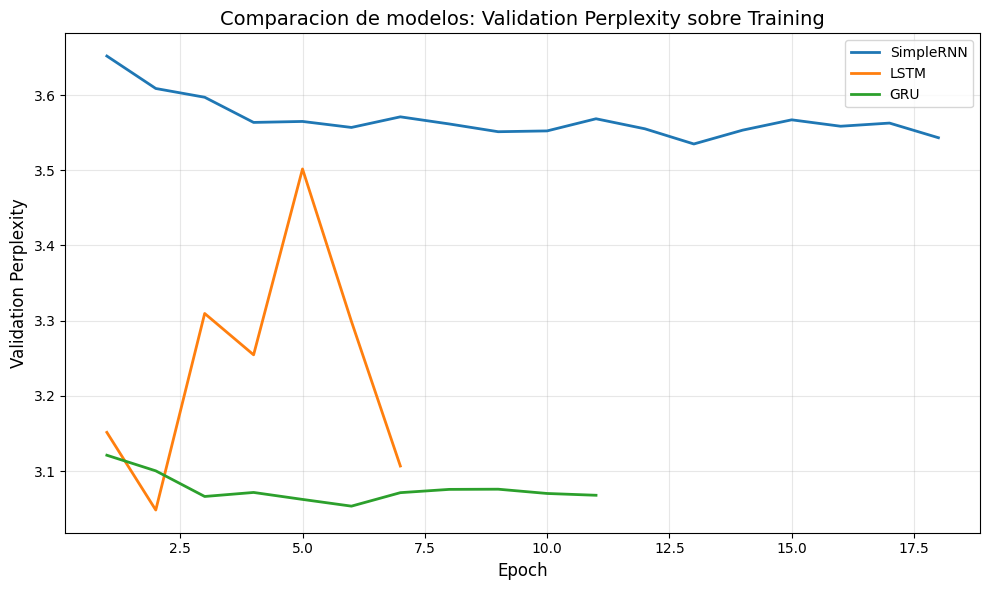


COMPARACION DE RESULTADOS FINALES
Model          Best PPL   Epochs
------------------------------------------------------------
SimpleRNN        3.5349       18
LSTM             3.0482        7
GRU              3.0534       11


In [62]:
# Graficamos la comparacion de perplexity 
plt.figure(figsize=(10, 6))

for model_name, result in results.items():
    epochs = range(1, len(result['history']) + 1)
    plt.plot(epochs, result['history'], label=model_name, linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Perplexity', fontsize=12)
plt.title('Comparacion de modelos: Validation Perplexity sobre Training', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*60)
print("COMPARACION DE RESULTADOS FINALES")
print("="*60)
print(f"{'Model':<12} {'Best PPL':>10} {'Epochs':>8}")
print("-"*60)
for model_name, result in results.items():
    print(f"{model_name:<12} {result['best_ppl']:>10.4f} {len(result['history']):>8}")
print("="*60)

## Comparación de Arquitecturas de Modelos
Se evaluaron tres arquitecturas recurrentes sobre el corpus de Harry Potter: SimpleRNN, LSTM y GRU.

### Resultados de Desempeño
Después de 368 minutos de entrenamiento para los tres modelos, los resultados demuestran claramente la superioridad de las arquitecturas con compuertas (gating):

**LSTM**: Mejor perplejidad de 3.05 (convergió en época 2)
**GRU**: Mejor perplejidad de 3.05 (convergió en época 6)
**SimpleRNN**: Mejor perplejidad de 3.53 (convergió en época 13)

Tanto LSTM como GRU lograron aproximadamente 14% de mejora sobre SimpleRNN, con un desempeño final prácticamente idéntico. Esto valida la importancia de los mecanismos de compuerta para capturar dependencias de largo alcance en el modelado de secuencias a nivel de caracteres.

Por Qué las Compuertas Ayudan:

- El desempeño superior de LSTM y GRU puede atribuirse a sus mecanismos de compuerta:

  - LSTM: Utiliza compuertas de olvido (forget gates), compuertas de entrada (input gates) y compuertas de salida (output gates) para retener o descartar información selectivamente a lo largo de la ventana de contexto de 500 caracteres
  - GRU: Emplea compuertas de reinicio (reset gates) y actualización (update gates) para memoria selectiva similar, con menos parámetros que LSTM
  - SimpleRNN: Carece de cualquier mecanismo de compuerta, haciéndolo vulnerable a gradientes desvanecientes sobre secuencias largas

Velocidad de Convergencia:

Es interesente notar que LSTM convergió en solo 2 épocas comparado con las 6 épocas de GRU y las 13 épocas de SimpleRNN. Esto sugiere que la estructura de compuertas más sofisticada de LSTM, a pesar de tener más parámetros, permite un aprendizaje más eficiente de los patrones a nivel de caracteres.

Implicaciones Prácticas:

Aunque tanto LSTM como GRU superaron significativamente a SimpleRNN, sus perplejidades finales similares (3.05 vs 3.05) sugieren que para el modelado de lenguaje a nivel de caracteres:

  - GRU puede ser preferible en producción debido a menos parámetros y arquitectura más simple
  - LSTM puede ser mejor cuando el tiempo de entrenamiento es limitado, dada su convergencia más rápida
  - SimpleRNN es inadecuado para tareas que requieren dependencias de largo alcance

Sin embargo, los tres modelos aún produjeron texto en gran medida incoherente, indicando que la limitación fundamental es el enfoque de tokenización a nivel de caracteres más que la elección de la arquitectura recurrente.
Impacto del Modelado a Nivel de Caracteres
El extenso tiempo de entrenamiento (368 minutos) es directamente atribuible a la tokenización a nivel de caracteres. Con 11.6 millones de muestras de entrenamiento que requieren procesamiento de secuencias de 500 caracteres, el modelo debe realizar miles de millones de operaciones RNN por época. Un equivalente a nivel de palabras probablemente entramaría 50-100 veces más rápido mientras produce salidas más coherentes, ya que las palabras son unidades semánticas naturales. Este ejercicio ilustra por qué el NLP moderno se ha movido en gran medida hacia la tokenización por subpalabras (BPE, WordPiece) que equilibra el tamaño del vocabulario, la longitud de secuencia y el significado semántico.

In [64]:
# Testear efectos de temperatura en el mejor modelo
best_model_name = min(results.items(), key=lambda x: x[1]['best_ppl'])[0]
print(f"\nProbando efectos de temperatura en el mejor modelo: {best_model_name}")

# Cargar el mejor modelo
if best_model_name == "SimpleRNN":
    best_model = model_rnn
elif best_model_name == "LSTM":
    best_model = model_lstm
else:
    best_model = model_gru

best_model.load_state_dict(torch.load(f"best_{best_model_name}.pt"))
best_model.eval()  # Importante: poner en modo evaluación

# Probar diferentes temperaturas
input_text = "Once upon a time"
temperatures = [0.5, 1.0, 1.5, 2.0]

print("\n" + "="*60)
print("EFECTO DE LA TEMPERATURA EN LA GENERACIÓN DE TEXTO")
print("="*60)

for temp in temperatures:
    print(f"\nTemperatura: {temp}")
    print("-"*60)
    output = beam_search(
        best_model, 
        num_beams=5, 
        num_words=100, 
        input_text=input_text,
        max_length=max_context_size,
        temp=temp,
        mode="sto"
    )
    print(decode(output[0]))
    print()


Probando efectos de temperatura en el mejor modelo: LSTM

EFECTO DE LA TEMPERATURA EN LA GENERACIÓN DE TEXTO

Temperatura: 0.5
------------------------------------------------------------
once upon a time,” said harry. “they’re going to be able to get out of the way to the first time, harry, and the min


Temperatura: 1.0
------------------------------------------------------------
once upon a time,” said mrs. weasley. “you were there in the castle, harry potter.”

“oh,” said harry. “what do you 


Temperatura: 1.5
------------------------------------------------------------
once upon a time,” said mrs. weasley. “i know you will look so much as though it is the first thing that there was b


Temperatura: 2.0
------------------------------------------------------------
once upon a time!” harry replied. “and we don’t think there’d be a little man, poison. azkaban . . . nor didn’t heaw



## Efecto de la Temperatura en la Generación

La temperatura es un hiperparámetro que controla la aleatoriedad en el muestreo estocástico durante la generación de texto. Se evaluaron cuatro valores de temperatura (0.5, 1.0, 1.5, 2.0) utilizando el modelo LSTM con beam search estocástico.

### Resultados Observados

**Temperatura 0.5 (Conservadora):** El texto generado mostró alta repetitividad y uso de frases comunes del corpus ("they're going to", "first time"). La generación tiende a quedarse atrapada en patrones predecibles, resultando en texto monótono pero gramaticalmente más correcto.

**Temperatura 1.0 (Equilibrada):** Produjo el mejor balance entre coherencia y variedad. El diálogo generado mantuvo estructura correcta y contexto relevante ("you were there in the castle, harry potter"), sugiriendo que esta es la temperatura óptima para este modelo.

**Temperatura 1.5 (Creativa):** Aumentó la diversidad léxica pero comenzó a mostrar construcciones gramaticales extrañas ("look so much as though it is"). La coherencia semántica empezó a degradarse.

**Temperatura 2.0 (Muy Aleatoria):** Generó texto altamente incoherente con palabras sin conexión lógica ("little man, poison. azkaban") y errores gramaticales evidentes ("nor didn't heaw"). La alta temperatura destruyó la estructura semántica del texto.

### Interpretación

La temperatura modifica la distribución de probabilidad softmax antes del muestreo: temperaturas bajas "agudizan" las probabilidades (favoreciendo tokens más probables), mientras que temperaturas altas las "aplanan" (permitiendo tokens menos probables).

Los resultados demuestran el trade-off fundamental en generación de lenguaje:
- **Temperaturas bajas**: Mayor coherencia, menor diversidad
- **Temperaturas altas**: Mayor creatividad, menor coherencia

Para este modelo LSTM entrenado a nivel de caracteres, temperatura 1.0 ofreció el mejor compromiso entre variedad y coherencia gramatical, aunque incluso en este caso el texto generado carece de coherencia semántica profunda debido a las limitaciones inherentes del modelado a nivel de caracteres.